In [25]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

In [26]:
mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['xtick.labelsize'] = 'x-large'
#mpl.rcParams['xtick.major.size'] = 5 
#mpl.rcParams['xtick.major.width'] = 1.5 
mpl.rcParams['ytick.labelsize'] = 'x-large'
#mpl.rcParams['ytick.major.size'] = 5 
#mpl.rcParams['ytick.major.width'] = 1.5 
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['axes.grid']=True
mpl.rcParams['axes.titlesize']=20
mpl.rcParams['axes.labelsize']=18
mpl.rcParams['legend.facecolor']='white'
mpl.rcParams['legend.fontsize']=18

folder='/home/patrick/Dropbox/School/phys344/Lab06/phys344lab06report'

In [8]:
v,dv,b,db=np.loadtxt('m34bv.raw',usecols=[3,4,5,6],unpack=True,skiprows=3)
bv=b-v
dbv=dv+db

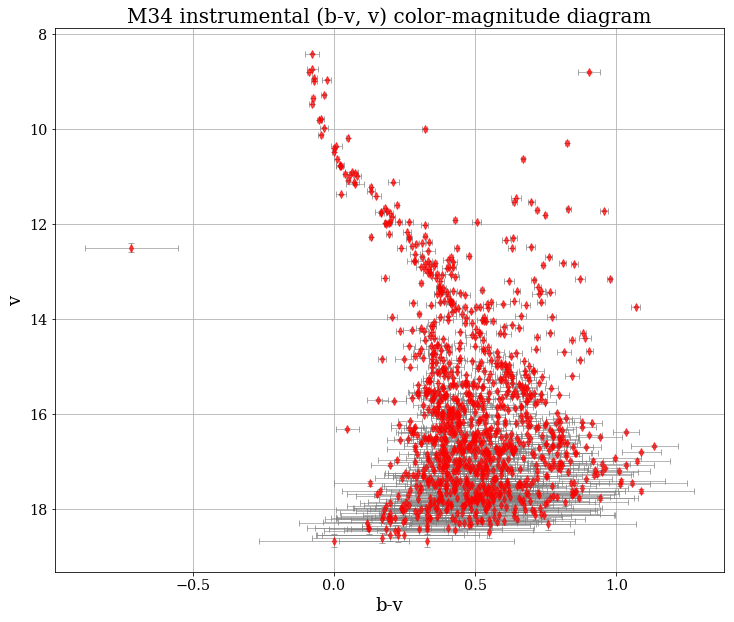

In [37]:
fig=plt.figure(figsize=(12,10))
ax=fig.add_subplot(111)
ax.errorbar(bv,v,dv,dbv,ms=5,capsize=3,elinewidth=0.8,ecolor='grey',fmt='rd',alpha=0.7)
ax.axes.invert_yaxis()
ax.set_xlabel('b-v')
ax.set_ylabel('v')
ax.set_title('M34 instrumental (b-v, v) color-magnitude diagram')
plt.show()